# MCMC tutorial: basics

Discussing the ins and outs of MCMC is certainly beyond the scope of this quick tutorial. For more information refer to [David Hogg's Probability Calculus for Inference](https://arxiv.org/pdf/1205.4446.pdf) and [Using Markov Chain Monte Carlo](https://arxiv.org/pdf/1710.06068.pdf).

To briefly state the problem: we want to determine posterior probability density function $p(\mathbf{r} | \mathcal D)$ given any prior knowledge $p(\mathbf{r})$ and likelihood function $p(\mathcal{D}|\mathbf{r})$:

$$ p(\mathbf{r} | \mathcal D) = \frac{1}{Z} p(\mathcal{D}|\mathbf{r}) p(\mathbf{r}), $$

where $Z = p(\mathcal D)$ is the normalization integral that is typically called *evidence*. It is difficult (read: impossible) to compute it, but fortunately we can get by with a proportionality instead:

$$ p(\mathbf{r} | \mathcal D) \propto p(\mathcal{D}|\mathbf{r}) p(\mathbf{r}). $$

The job of MCMC is to provide you with a *fair* sampling from the posterior pdf so that you can evaluate the heuristic uncertainty on the adjusted parameters.

In this tutorial we will cover the basics of using MCMC to sample the parameter space near the minimum. We will discuss several "gotchas" and get into gear for applying the principles we cover here to PHOEBE and eclipsing binaries. We assume basic familiarity with parametrization, model fitting and python.

For the purpose of this tutorial we will use [emcee](https://emcee.readthedocs.io/en/stable/), a popular mcmc sampler written by [Dan Foreman-Mackey](https://github.com/dfm), but the principles apply equally to any other implementation out there. Let's get started by importing relevant modules:

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

Now let's write a data generator function; to start with, we will use a straight line with some white noise added to it, and we will make this function more feature-rich as we go along.

In [2]:
def data_generator(x, b=0.7, c=-0.25, s=0.05):
    noise = np.random.normal(loc=0, scale=s, size=len(x))
    return np.array((x, b*x+c+noise, s*np.ones_like(x))).T

Here, `x` is the input array of x-values, `b` and `c` are slope and intercept, respectively, and `s` is per-point standard deviation. The function returns a `(len(x), 3)`-shaped array with `x`, `y` and `s` for the three columns. We now generate data on the unit interval and plot it to see what it looks like:

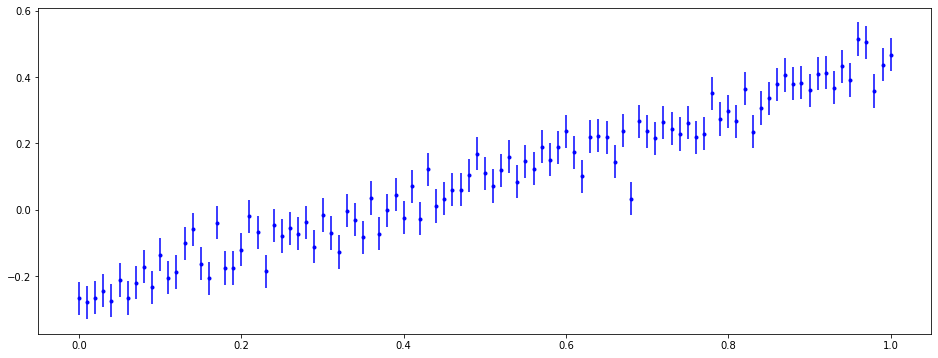

In [3]:
d = data_generator(x=np.linspace(0, 1, 101))
plt.figure(figsize=(16,6))
_ = plt.errorbar(d[:,0], d[:,1], yerr=d[:,2], fmt='b.')

Now comes the crux of MCMC: the log-likelihood function. This function informs MCMC how consistent the parameters at hand are with the data. We will talk about some of the considerations later on, but right now let us assume the simplest possible case where are modeling function is perfect and our noise is white. In that case, the measure of the likelihood is a simple gaussian:

$$ p(\mathcal{D}|\mathbf{r}) = \exp \left( -\frac 12 \sum_k \frac{[y_k - y(x_k; \mathbf{r})]^2}{\sigma_k^2} \right), $$

where $y_k$ are y-values, $y(x_k; \mathbf{r})$ is a modeling function evaluated in $x_k$ for parameters $\mathbf{r} = \{b, c\}$, and $\sigma_k$ are per-point standard deviations. The *log*-likelihood is then simply:

$$ \log p(\mathcal{D}|\mathbf{r}) = -\frac 12 \sum_k \frac{[y_k - y(x_k; \mathbf{r})]^2}{\sigma_k^2}. $$

Let's codify it:

In [4]:
def logp(x, d):
    return -0.5*np.sum( ((d[:,1]-x[0]*d[:,0]-x[1])/d[:,2])**2 )# + np.log(2*np.pi*d[:,2]**2) )

The emcee sampler is an *ensemble* sampler, meaning that it distributes sampling across *walkers*. Each walker traverses the parameter space, with each subsequent step being informed by the position of all other walkers in the ensemble. Thus, emcee needs to know how many walkers to use, what is the dimension of the parameter space, and what are the starting values for each walker. Let's set those up! The dimension of the parameter space in our case is, of course, 2 (spun by $b$ and $c$). The number of walkers is not critical as long as it's larger than several times the dimension of the parameter space. As for the starting values, we will draw them from a uniform distribution $\mathcal U(-1, 1)$.

In [5]:
nwalkers = 32
ndim = 2

r0 = np.random.uniform(low=-1, high=1, size=(nwalkers, ndim))

Next, initialize emcee's Ensemble sampler; we pass the number of walkers, parameter space dimension, the log-probability function and any other arguments that the log-likelihood function needs, in our case the data:

In [6]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logp, args=[d])

We are now set to run the sampler. Given that we used a uniform distribution to draw starting points for both parameters and each of the 32 walkers, we expect that initial values will be all over the place. We will discard those later -- this is called "burn-in". Let's run the sampler for, say, 2,100 iterations: 100 iterations are burn-in and another 2000 iterations to achieve convergence. We will evaluate below if that was sufficient.

In [7]:
state = sampler.run_mcmc(r0, 2100)
r = sampler.get_chain(flat=True, thin=1, discard=100)

The emcee results are accessed by the `get_chain()` method; it takes a few optional parameters: `flat` (boolean; default=False), to flatten the chain across the ensamble; `thin=N` (int, default=1), to take every `N`-th step from the chain; and `discard=N` (int, default=0), to discard the first `N` steps in the chain, i.e. burn-in. We will discard the first 500 samples as the parameter values settle in. The method returns an array of shape `(niters, nwalkers, ndim)` if `flat=False`, and `(niters*nwalkers, ndim)` if `flat=True`.

Let's take a look at the histogram of our parameter values:

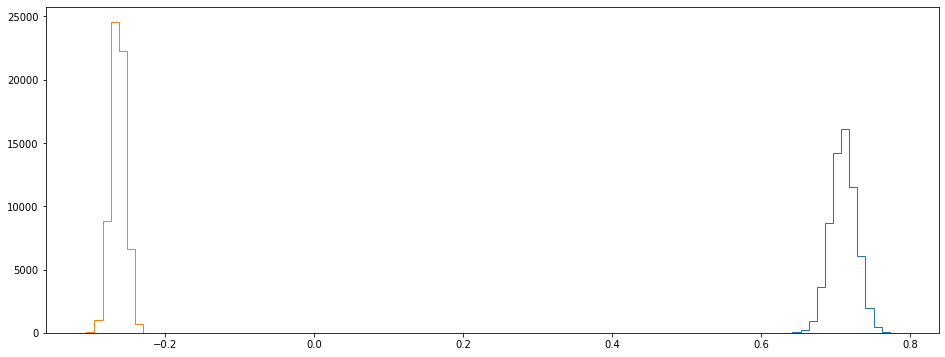

In [8]:
plt.figure(figsize=(16,6))
_ = plt.hist(r, 100, histtype='step')

Not too shabby given that the true values of the parameters are $b=0.7$ and $c=-0.25$. Before we proceed to plot this result in a more useful format, let us note two important quantities that we can use to evaluate the sampler's behavior and convergence: *acceptance fraction* and *autocorrelation time*. 

* Acceptance fraction gives us the fraction of the proposed steps that ended up being accepted; if this value is too low, then the sampler is "stuck" as most of the proposed steps are rejected, and sampling will *not* be representative of the parameter space; conversely, if acceptance fraction is too high, then all walkers are random-walking without "guidance" from the log-likelihood function. There's no preset value of the acceptance fraction that we should aim for, and every case will be different, but we do not want to be close to either the low or the high extremum.

* Autocorrelation time provides us with the number of iterations required to *independently* sample the data. Effectively, this is the span of the sampler's "memory" -- the samples are essentially independent from the samples before the autocorrelation time. We want the autocorrelation time to be as small as possible given that we then need to do fewer computations to get the same number of independent samples. In practical terms, autocorrelation time is an estimate of the sampler's convergence. Typically convergence will be reached in a few autocorrelation times (cf.  [Foreman-Mackey et al. 2012](https://arxiv.org/pdf/1202.3665.pdf)).

In terms of code, we have these readily available:

In [9]:
af = np.mean(sampler.acceptance_fraction)
print(f'Acceptance fraction: {af:3.3f}')

Acceptance fraction: 0.712


In [10]:
at = np.mean(sampler.get_autocorr_time())
print(f'Autocorrelation time: {at:3.1f} iterations')

Autocorrelation time: 24.2 iterations


Looking at these two values we see that choosing 2,100 iterations was quite suitable to achieve convergence. We can visualize convergence by plotting all walkers' chains as a function of iteration:

Text(0, 0.5, '$c$')

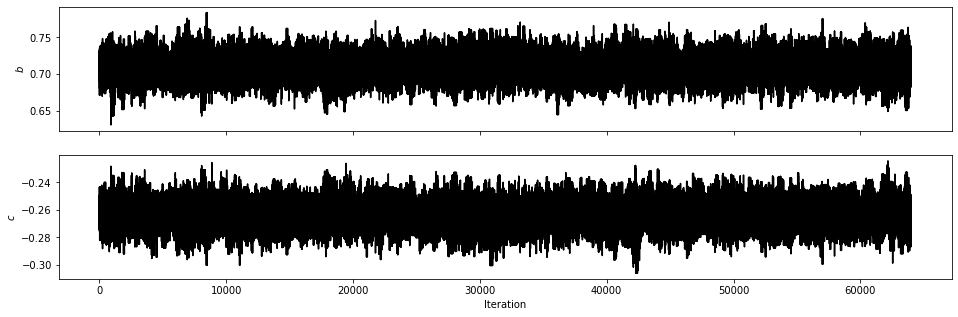

In [11]:
fig, axes = plt.subplots(2, figsize=(16, 5), sharex=True)
axes[0].plot(r[:,0], 'k-')
axes[1].plot(r[:,1], 'k-')
axes[1].set_xlabel('Iteration')
axes[0].set_ylabel(r'$b$')
axes[1].set_ylabel(r'$c$')

Now let us replot parameter distributions in a corner plot. For that we will need another module, [corner](https://corner.readthedocs.io/en/latest/):

b =  0.710 +/- 0.017
c = -0.263 +/- 0.010


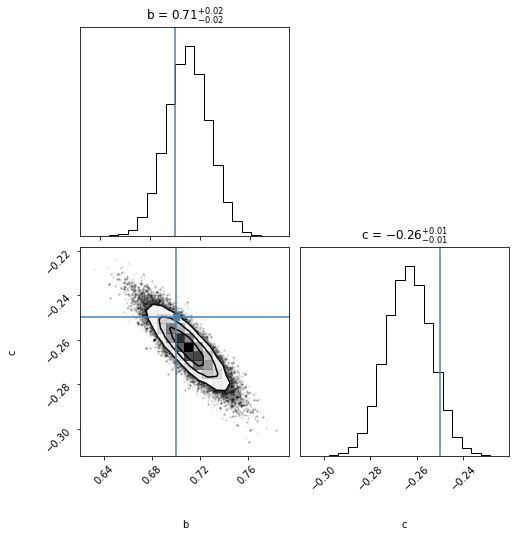

In [12]:
import corner
fig = plt.figure(figsize=(8,8))
corner.corner(r, labels=[r'b', r'c'], truths=[0.7, -0.25], show_titles=True, fig=fig)
best_fit_b, uncert_b = np.mean(r[:,0]), np.std(r[:,0])
best_fit_c, uncert_c = np.mean(r[:,1]), np.std(r[:,1])
print(f'b = {best_fit_b: 3.3f} +/- {uncert_b:3.3f}')
print(f'c = {best_fit_c: 3.3f} +/- {uncert_c:3.3f}')

The corner plot depicts some (but not all! - we return to this below) of the most relevant results from the sampler. The diagonal panels provide us with parameter posteriors, along with their estimated values. The off-diagonal panel provides us with the 2-parameter cross-section that measures the correlation between the parameters.

We can now use posterior probability density functions (PDFs) to sample the values for $b$ and $c$ and plot the $y(\mathbf x; \mathbf r)$ model. Let's write a function that will average a given number of random draws from the entire chain and return their mean and 1-$\sigma$ deviation:

In [13]:
def draw_subsample(r, size=1000):
    inds = np.random.randint(len(r), size=1000)
    models = np.array([r[k,0]*d[:,0]+r[k,1] for k in inds])
    model_mean = models.mean(axis=0)
    model_std = models.std(axis=0)
    
    return (model_mean, model_std)

def plot_subsample(model_mean, model_std, fig=None, yerr=True):
    if fig is None:
        plt.figure(figsize=(16,6))
    if yerr:
        plt.errorbar(d[:,0], d[:,1], yerr=d[:,2], fmt='b.')
    else:
        plt.plot(d[:,0], d[:,1], 'b.')
    plt.plot(d[:,0], model_mean, 'r-')
    plt.fill_between(d[:,0], model_mean-model_std, model_mean+model_std, alpha=0.3)

Plot a subsample with, say, 1000 samples:

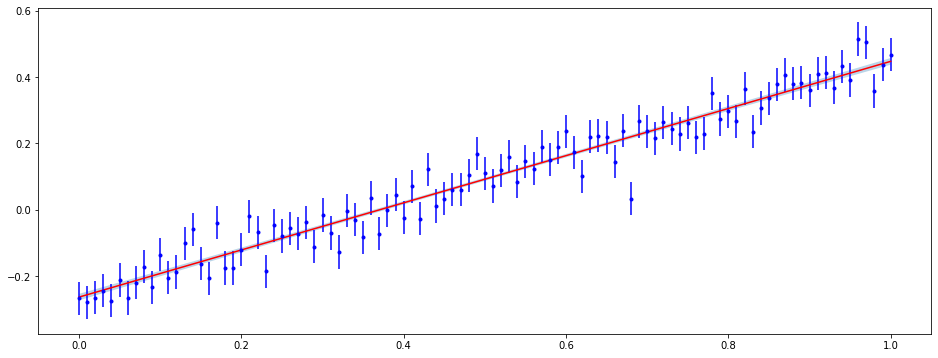

In [14]:
model_mean, model_std = draw_subsample(r)
plot_subsample(model_mean, model_std)

Note that it doesn't matter whether we sample across the entire chain or the last few iterations becuase the chain is converged (cf. convergence plots and the autocorrelation time from before).

It is instructive to calculate the reduced $\chi^2$ at this point, to see that the best-fit model adequately fits the data:

In [15]:
chi2 = np.sum(((d[:,1]-best_fit_b*d[:,0]-best_fit_c)/d[:,2])**2)
dof = len(d[:,0])-2
rchi2 = chi2/dof
print(f'reduced chi2: {rchi2:3.3f}')

reduced chi2: 0.946


Reduced chi2 can only be used for linear models with true gaussian errors, which is what we have, at least for now. This is a textbook case of properly applied $\chi^2_r$, and the value confirms that the means of the parameter posteriors describe the data well.

Now let's address a problem that the spread plot above demonstrates. The width of the posterior scales with $\sqrt{N}$, where $N$ is the number of data points. This means that the $\pm$1-$\sigma$ spread will include progressively fewer data points as, under the assumption of identically and independently distributed errors and following from the central limit theorem, $\sigma_p^2 = \sigma^2 / N$. We can put this to test by comparing the distribution of data residuals normalized to observed per-point uncertainty and normalized to the posterior width uncertainty, corrected for $\sqrt N$:

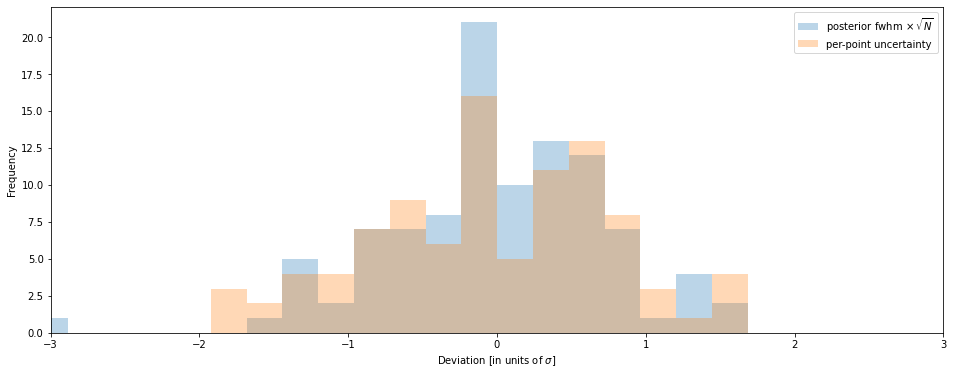

In [16]:
fig = plt.figure(figsize=(16,6))
plt.xlim(-3, 3)
data_spread = (d[:,1]-model_mean)/d[:,2]
model_spread = (d[:,1]-model_mean)/(model_std*np.sqrt(len(d[:,0])))
freqs, ranges, _ = plt.hist(model_spread, 20, alpha=0.3, label=r'posterior fwhm$\,\times \sqrt{N}$')
plt.xlabel(r'Deviation [in units of $\sigma$]')
plt.ylabel('Frequency')
plt.hist(data_spread, bins=ranges, alpha=0.3, label=r'per-point uncertainty')
_ = plt.legend()

In reality, per-point uncertainties will *not* be i.i.d., and chi2 will not be the optimal cost function. Moreover, the $\sqrt{N}$ dependence is problematic because, as $N \to \infty$, posteriors tend to delta functions and parameter uncertainties tend to 0. In that regime the uncertainty in parameters becomes exclusively a function of the noise model, and those are notoriosly difficult to formulate reliably.

There are several possible approaches to address the $\sqrt{N}$ dependence in the absence of a reliable noise model. One would be to renormalize per-point deviations in the likelihood function by $\sqrt{N}$, effectively making the log-likelihood independent of $N$; this is not good statistical practice because it implies that adding more points does not improve the model. The other would be to consider the model itself, $y(x) = bx+c$, *uncertain*:

$$ y(x) = bx + c + \mathcal{N}(0, \sigma), $$

where $\sigma$ is the measure of the model uncertainty. Yet another would be to add a "pedestal" sigma into the log-likelihood denominator to ameliorate the issue, but that will only prolong the inevitable as $N \to \infty$ and it should be making us uneasy because the choice of that pedestal value is ad-hoc. Let's try to implement these and see how the results change. 

### Rescaling log-likelihood?

Acceptance fraction: 0.715
Autocorrelation time: 29.7 iterations
b =  0.709 +/- 0.169
c = -0.264 +/- 0.097


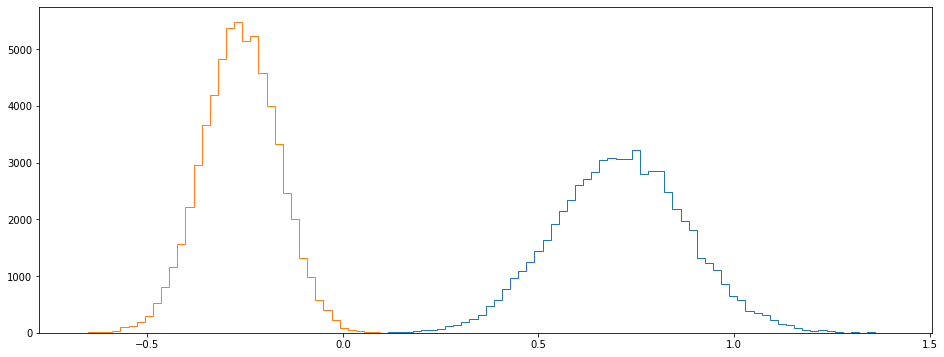

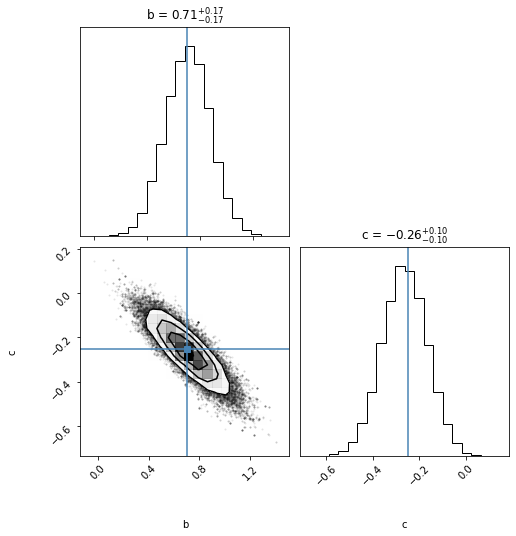

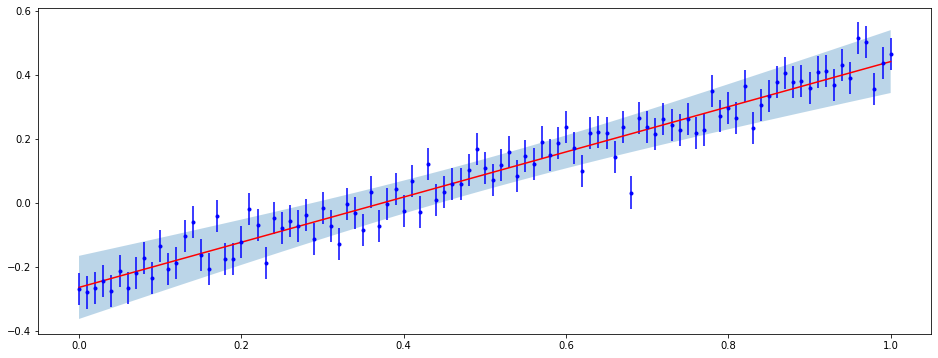

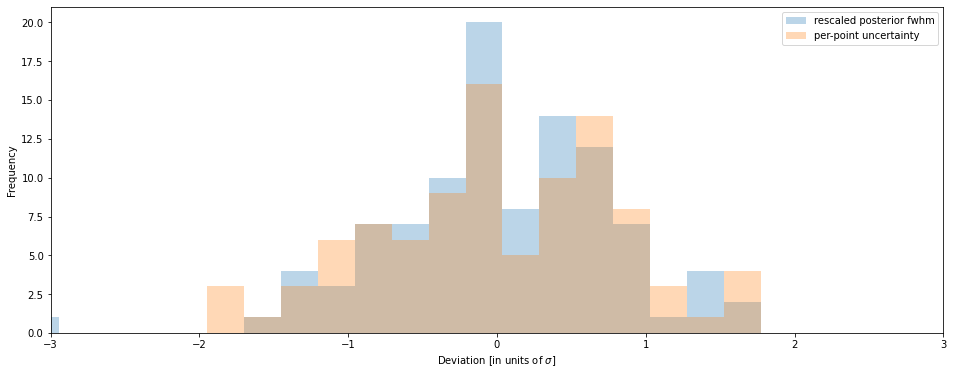

In [17]:
def logp(x, d):
    model = x[0]*d[:,0]+x[1]
    return -0.5/len(d[:,0])*np.sum( ((d[:,1]-model)/d[:,2])**2 )# + np.log(2*np.pi*d[:,2]**2) )

nwalkers = 32
ndim = 2

r0 = np.random.uniform(low=-1, high=1, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp, args=[d])
state = sampler.run_mcmc(r0, 2100)
r = sampler.get_chain(flat=True, thin=1, discard=100)

plt.figure(figsize=(16,6))
_ = plt.hist(r, 100, histtype='step')

af = np.mean(sampler.acceptance_fraction)
print(f'Acceptance fraction: {af:3.3f}')

at = np.mean(sampler.get_autocorr_time())
print(f'Autocorrelation time: {at:3.1f} iterations')

fig = plt.figure(figsize=(8,8))
corner.corner(r, labels=[r'b', r'c'], truths=[0.7, -0.25], show_titles=True, fig=fig)
best_fit_b, uncert_b = np.mean(r[:,0]), np.std(r[:,0])
best_fit_c, uncert_c = np.mean(r[:,1]), np.std(r[:,1])
print(f'b = {best_fit_b: 3.3f} +/- {uncert_b:3.3f}')
print(f'c = {best_fit_c: 3.3f} +/- {uncert_c:3.3f}')

model_mean, model_std = draw_subsample(r)
plot_subsample(model_mean, model_std)

fig = plt.figure(figsize=(16,6))
plt.xlim(-3, 3)
data_spread = (d[:,1]-model_mean)/d[:,2]
model_spread = (d[:,1]-model_mean)/model_std
freqs, ranges, _ = plt.hist(model_spread, 20, alpha=0.3, label=r'rescaled posterior fwhm')
plt.xlabel(r'Deviation [in units of $\sigma$]')
plt.ylabel('Frequency')
plt.hist(data_spread, bins=ranges, alpha=0.3, label=r'per-point uncertainty')
_ = plt.legend()

This is clearly worse than what the data allow; and it won't get any better with increasing $N$.

### Adding "fuzz" to the likelihood function?

In [18]:
def logp(x, d, sigma=0.05):
    model = x[0]*d[:,0]+x[1]+np.random.normal(0, sigma, size=len(d[:,0]))
    return -0.5*np.sum( ((d[:,1]-model)/d[:,2])**2 )# + np.log(2*np.pi*d[:,2]**2) )

nwalkers = 32
ndim = 2

r0 = np.random.uniform(low=-1, high=1, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp, args=[d])
state = sampler.run_mcmc(r0, 10100)
r = sampler.get_chain(flat=True, thin=1, discard=100)

af = np.mean(sampler.acceptance_fraction)
print(f'Acceptance fraction: {af:3.3f}')

# at = np.mean(sampler.get_autocorr_time())
# print(f'Autocorrelation time: {at:3.1f} iterations')

Acceptance fraction: 0.002


Well that sums it up for that idea: as the number of iterations grows larger, acceptance fraction tends to 0. In other words, we are confusing the sampler to the point that it's stuck and cannot converge.

### Adding a pedestal?

Acceptance fraction: 0.711
Autocorrelation time: 27.7 iterations
b =  0.708 +/- 0.070
c = -0.263 +/- 0.040


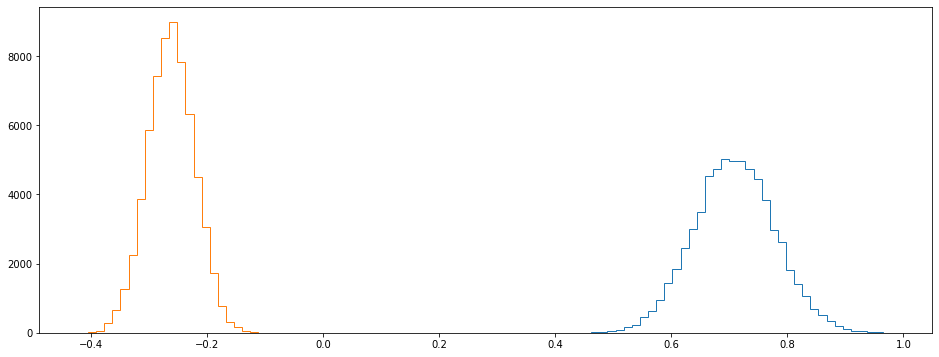

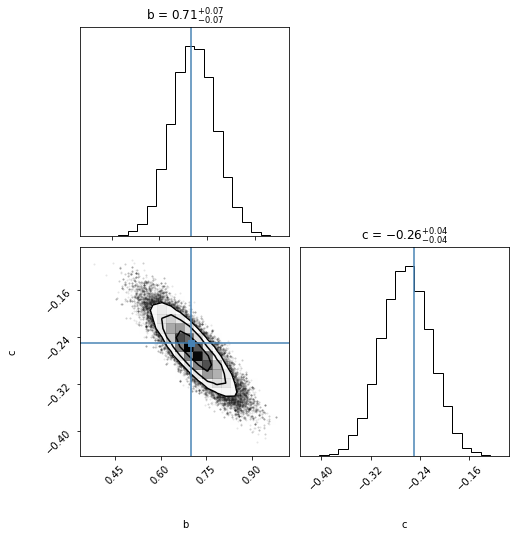

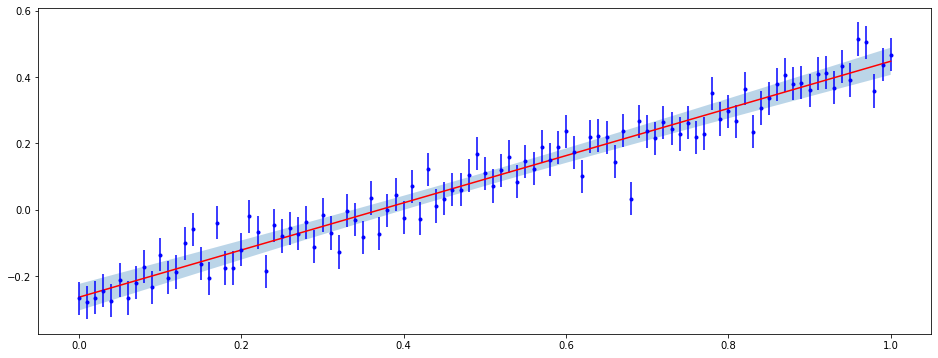

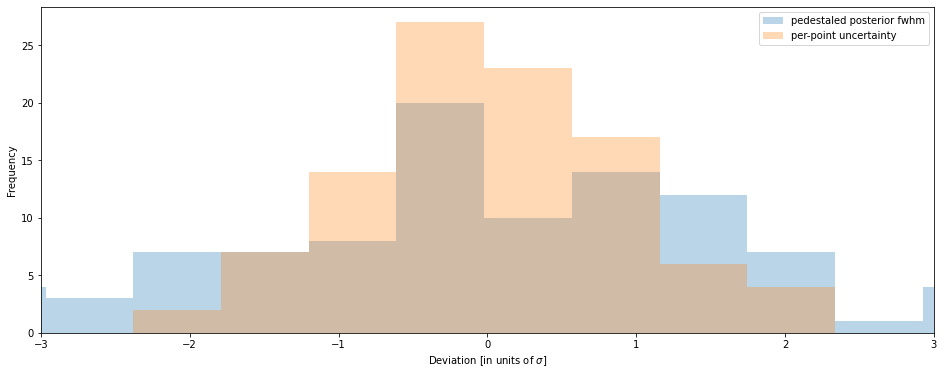

In [19]:
def logp(x, d, p=0.2):
    model = x[0]*d[:,0]+x[1]
    return -0.5*np.sum((d[:,1]-model)**2/(d[:,2]**2+p**2) )# + np.log(2*np.pi*d[:,2]**2) )

nwalkers = 32
ndim = 2

r0 = np.random.uniform(low=-1, high=1, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp, args=[d])
state = sampler.run_mcmc(r0, 2100)
r = sampler.get_chain(flat=True, thin=1, discard=100)

plt.figure(figsize=(16,6))
_ = plt.hist(r, 100, histtype='step')

af = np.mean(sampler.acceptance_fraction)
print(f'Acceptance fraction: {af:3.3f}')

at = np.mean(sampler.get_autocorr_time())
print(f'Autocorrelation time: {at:3.1f} iterations')

fig = plt.figure(figsize=(8,8))
corner.corner(r, labels=[r'b', r'c'], truths=[0.7, -0.25], show_titles=True, fig=fig)
best_fit_b, uncert_b = np.mean(r[:,0]), np.std(r[:,0])
best_fit_c, uncert_c = np.mean(r[:,1]), np.std(r[:,1])
print(f'b = {best_fit_b: 3.3f} +/- {uncert_b:3.3f}')
print(f'c = {best_fit_c: 3.3f} +/- {uncert_c:3.3f}')

model_mean, model_std = draw_subsample(r)
plot_subsample(model_mean, model_std)

fig = plt.figure(figsize=(16,6))
plt.xlim(-3, 3)
data_spread = (d[:,1]-model_mean)/d[:,2]
model_spread = (d[:,1]-model_mean)/model_std
freqs, ranges, _ = plt.hist(model_spread, 20, alpha=0.3, label=r'pedestaled posterior fwhm')
plt.xlabel(r'Deviation [in units of $\sigma$]')
plt.ylabel('Frequency')
plt.hist(data_spread, bins=ranges, alpha=0.3, label=r'per-point uncertainty')
_ = plt.legend()

We could think of ways to set the pedestal dynamically, but fundamentally it will always butt against the same issue: it will be ad-hoc, based on what we want the log-likelihood to do, rather than what data inform it to do.

### The role of per-point uncertainties

Now let's see what happens if we leave the data as they are but we artificially increase per-point sigmas:

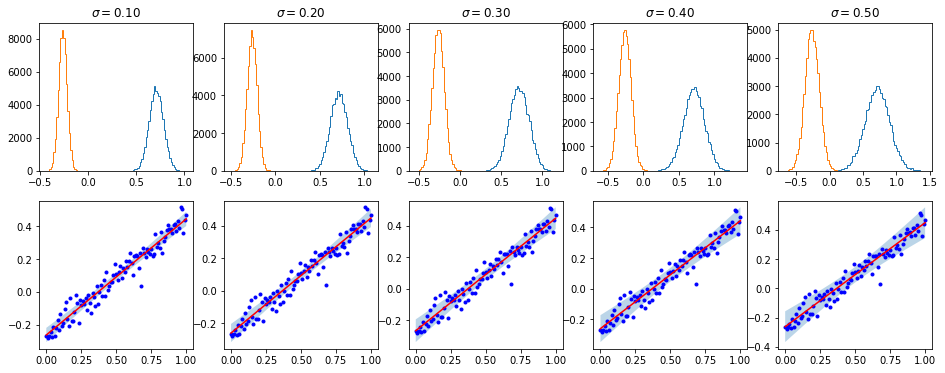

In [20]:
fig = plt.figure(figsize=(16,6))
for s in range(1, 6):
    plt.subplot(2, 5, s)
    plt.title(r'$\sigma = %2.2f$' % (0.1*s))
    d[:,2] = 0.1*s
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logp, args=[d])
    state = sampler.run_mcmc(r0, 2100)
    r = sampler.get_chain(flat=True, discard=100)
    _ = plt.hist(r, 100, histtype='step')
    plt.subplot(2, 5, s+5)
    mm, ms = draw_subsample(r)
    plot_subsample(mm, ms, fig=fig, yerr=False)

To wrap up, let's reset the uncertainty to its true value:

In [21]:
d[:,2] = 0.05

### Correlation

How about if we add another parameter that is 100% correlated, for example $y = kx+n+c$?

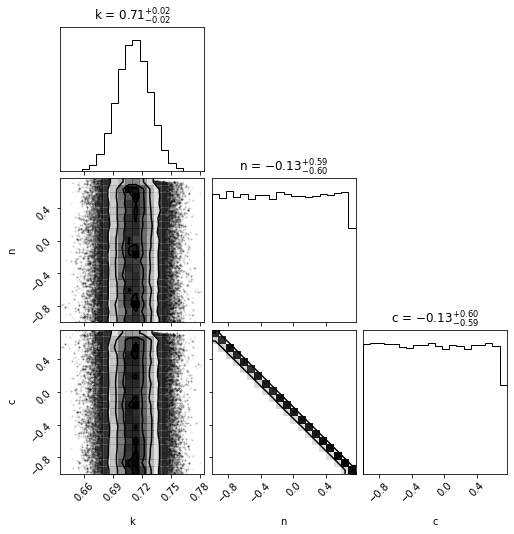

In [22]:
def logp2(x, d):
    if (x[0] < -1) | (x[0] > 1) | (x[1] < -1) | (x[1] > 1) | (x[2] < -1) | (x[2] > 1):
        return -np.inf
    return -0.5*np.sum( (d[:,1]-(x[0]*d[:,0]+x[1]+x[2]))**2/d[:,2]**2 )

nwalkers = 32
ndim = 3
p0 = np.random.uniform(low=-1, high=1, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp2, args=[d])
state = sampler.run_mcmc(p0, 10000)
flat_samples = sampler.get_chain(flat=True, discard=100)
fig = corner.corner(flat_samples, labels=[r'k', r'n', r'c'], show_titles=True)

### Invalid model

Now imagine we have a poor model that cannot adequately describe the data. Will that show up in the posteriors? To demonstrate this, let's redefine our data generator function to synthesize quadratic data, but we will still fit them with a linear function.

In [23]:
def data_generator(x, a=-1.0, b=0.7, c=-0.25, s=0.05):
    noise = np.random.normal(loc=0, scale=s, size=len(x))
    return np.array((x, a*x**2+b*x+c+noise, s*np.ones_like(x))).T

Let's get a data sample to work with and plot it to see what it looks like:

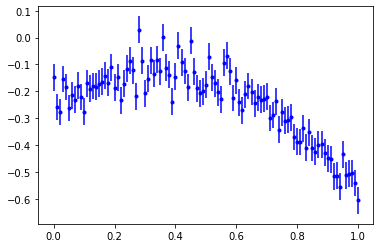

In [24]:
d = data_generator(x=np.linspace(0, 1, 101))
_ = plt.errorbar(d[:,0], d[:,1], yerr=d[:,2], fmt='b.')

We now do what we did above: fit a linear function and look at convergence and the posteriors *without* looking at the fit:

b = -0.327 +/- 0.070
c = -0.074 +/- 0.041


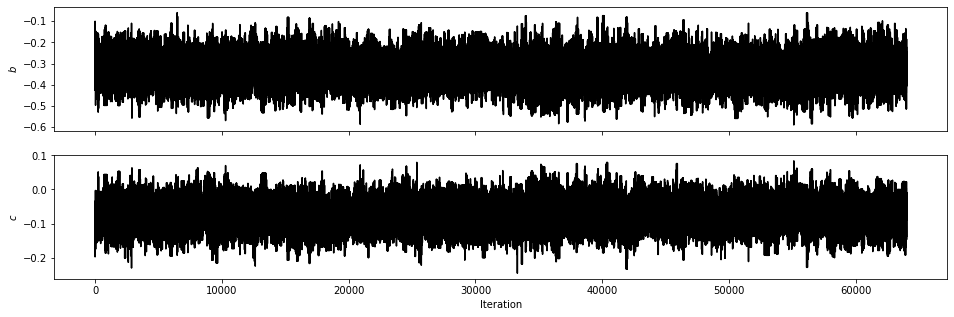

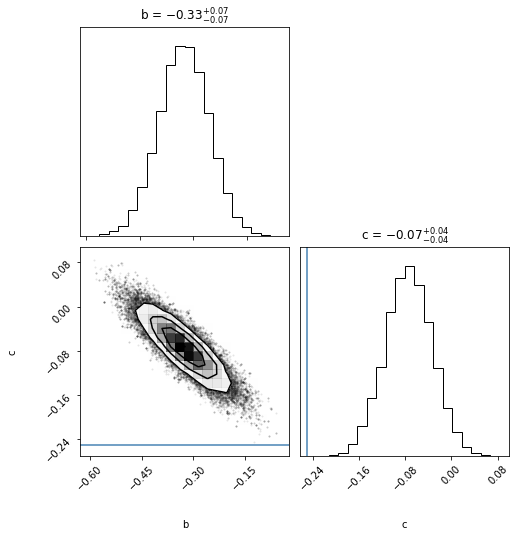

In [25]:
nwalkers = 32
ndim = 2
p0 = np.random.uniform(low=-1, high=1, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp, args=[d])
state = sampler.run_mcmc(r0, 2100)
r = sampler.get_chain(flat=True, thin=1, discard=100)

fig, axes = plt.subplots(2, figsize=(16, 5), sharex=True)
axes[0].plot(r[:,0], 'k-')
axes[1].plot(r[:,1], 'k-')
axes[1].set_xlabel('Iteration')
axes[0].set_ylabel(r'$b$')
axes[1].set_ylabel(r'$c$')

fig = plt.figure(figsize=(8,8))
corner.corner(r, labels=[r'b', r'c'], truths=[0.7, -0.25], show_titles=True, fig=fig)
best_fit_b, uncert_b = np.mean(r[:,0]), np.std(r[:,0])
best_fit_c, uncert_c = np.mean(r[:,1]), np.std(r[:,1])
print(f'b = {best_fit_b: 3.3f} +/- {uncert_b:3.3f}')
print(f'c = {best_fit_c: 3.3f} +/- {uncert_c:3.3f}')

Pretty convincing, right? Yet the fit itself is total garbage:

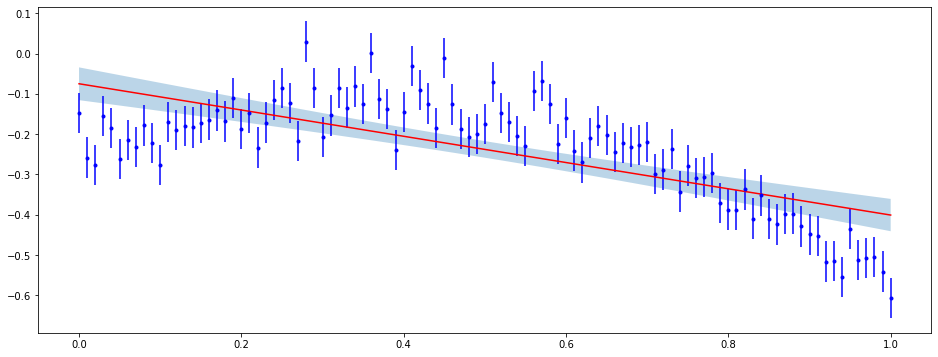

In [26]:
model_mean, model_std = draw_subsample(r)
plot_subsample(model_mean, model_std)

Distribution of the residuals is equally bad:

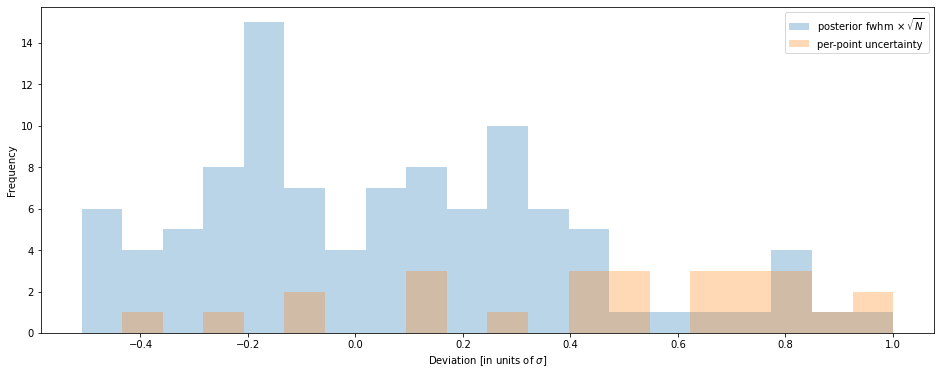

In [27]:
fig = plt.figure(figsize=(16,6))
data_spread = (d[:,1]-model_mean)/d[:,2]
model_spread = (d[:,1]-model_mean)/(model_std*np.sqrt(len(d[:,0])))
freqs, ranges, _ = plt.hist(model_spread, 20, alpha=0.3, label=r'posterior fwhm$\,\times \sqrt{N}$')
plt.xlabel(r'Deviation [in units of $\sigma$]')
plt.ylabel('Frequency')
plt.hist(data_spread, bins=ranges, alpha=0.3, label=r'per-point uncertainty')
_ = plt.legend()

Thus, we have to estimate the goodness of fit *in addition* to getting the posteriors as those are useful *only* if the model itself describes the data well. The obvious metric is the reduced chi2:

In [28]:
chi2 = np.sum(((d[:,1]-best_fit_b*d[:,0]-best_fit_c)/d[:,2])**2)
dof = len(d[:,0])-2
rchi2 = chi2/dof
print(f'reduced chi2: {rchi2:3.3f}')

reduced chi2: 3.651


This should raise all sorts of red flags that something is terribly wrong.